In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import tensorflow as tf
import tensorflow.distributions
from tensorflow.distributions import Dirichlet, Multinomial
from scipy.stats import entropy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
np.set_printoptions(suppress=True)

import data_handler as dh
import sinkhorn as skh
import oracles as oracle
import model as md
import time
import pickle

import os

In [3]:
np.version.version

'1.18.2'

In [4]:
net_name = 'data/EMA_net.tntp'
trips_name = 'data/EMA_trips.tntp'

handler = dh.DataHandler()
graph_data = handler.GetGraphData(net_name, columns_order = np.array([0, 1, 2, 3, 4]))
# graph_data['graph_table']['Capacity'] = 2.5 * graph_data['graph_table']['Capacity']

graph_correspondences, total_od_flow = handler.GetGraphCorrespondences(trips_name)

graph_data['graph_table'].head()
n = np.max(graph_data['graph_table']['Init node'].as_matrix())

In [5]:
graph_data['graph_table'].head()

,Init node,Term node,Capacity,length,Free Flow Time
0,1,3,4938.061523,16.106817,0.238965
1,3,1,5254.128418,16.057131,0.240297
2,1,7,7309.824707,16.058741,0.222813
3,7,1,7388.626953,15.865263,0.218902
4,1,9,1164.374878,17.455400,0.402046


In [6]:
graph_data['graph_table']['Orig Free Flow Time'] = graph_data['graph_table']['Free Flow Time']

In [7]:
df = graph_data['graph_table']
df[df['Init node'] == 1].head()

,Init node,Term node,Capacity,length,Free Flow Time,Orig Free Flow Time
0,1,3,4938.061523,16.106817,0.238965,0.238965
2,1,7,7309.824707,16.058741,0.222813,0.222813
4,1,9,1164.374878,17.455400,0.402046,0.402046


In [8]:
df.shape

(258, 6)

In [9]:
correspondence_matrix = handler.from_dict_to_cor_matr(graph_correspondences, n)
# T = handler.create_C(df, n, column_name='Free Flow Time')
# C = handler.create_C(df, n, column_name='length')

T = handler.get_T_from_shortest_distances(n, graph_data)

# np.savetxt('data/T.csv', T, delimiter=',')

L = np.nansum(correspondence_matrix, axis=1)
W = np.nansum(correspondence_matrix, axis=0)

people_num = np.nansum(L)

L = handler.distributor_L_W(L)
W = handler.distributor_L_W(W)

L = L / np.nansum(L)
W = W / np.nansum(W)

print('people_num: ', people_num)

people_num:  65576.37543100001


In [10]:
T[0][6]

0.22281299531459808

##### Запускаем Синхорна-Универсальный

In [12]:
np.set_printoptions(formatter={'all':lambda x: str(x)})
T_d = np.inf
eps = 10**(-5)
T_d_list = []
result_history = []
best_reconstruction_error_history = []
multi_stage_i = 0

T_orig = handler.get_T_from_shortest_distances(n, graph_data)
T_prev = np.copy(T_orig)
T = np.copy(T_orig)
alpha = 2.5402

best_matrix = None
min_reconstruction_error = np.inf
rec_list = []
# alpha_list = []
time_ratio_list = []
flow_excess_list = []

num_iter = 2500  # for sink
max_iter = 5000  # for univ


lambda_L = np.full((n, ), 0.0, dtype=np.double)
lambda_W = np.full((n, ), 0.0, dtype=np.double)

s = skh.Sinkhorn(n, L, W, people_num, num_iter, eps)

while multi_stage_i < 30:
    
    print('iter: ', multi_stage_i)
    
    if multi_stage_i == 0: 
        cost_matrix = np.nan_to_num(alpha * T_orig, nan=100)
    else:
        cost_matrix = np.nan_to_num(alpha * T, nan=100)
        
    rec, lambda_L, lambda_W = s.iterate(cost_matrix, lambda_L, lambda_W)
    
    print('Sinkhorn end, univ start \n')
    
    
    best_correcpondences_dict = handler.from_cor_matrix_to_dict(rec)

    model = md.Model(graph_data, best_correcpondences_dict, 
                     total_od_flow, mu = 0.25, rho = 0.15) # B, for stable D mu=0.0
    
    for i, eps_abs in enumerate(np.logspace(1,3,1)):
        
        print('eps_abs =', eps_abs)
        solver_kwargs = {'eps_abs': eps_abs,
                         'max_iter': max_iter,
                         'multistage_i': multi_stage_i}
        tic = time.time()
        result = model.find_equilibrium(solver_name = 'ugd', 
                                        solver_kwargs = solver_kwargs, 
                                        verbose = False)
        
    toc = time.time()
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    
    result_history.append(result)
    
    graph_data['graph_table']['Free Flow Time'] = result['times']
    T = handler.get_T_from_shortest_distances(n, graph_data)
    
    flows = result['flows']
    
    multi_stage_i += 1
    break;

iter:  0
Sinkhorn end, univ start 

eps_abs = 10.0
Elapsed time: 2182 sec


##### vizualization!

In [82]:
x_0 = 16
s = 0
nums = 0
for i in range(0, 30):
    nums = 2182 / x_0
    x_0 += 5
    print(nums)
    s += nums

136.375
103.9047619047619
83.92307692307692
70.38709677419355
60.611111111111114
53.21951219512195
47.43478260869565
42.78431372549019
38.964285714285715
35.77049180327869
33.06060606060606
30.732394366197184
28.710526315789473
26.938271604938272
25.372093023255815
23.978021978021978
22.729166666666668
21.603960396039604
20.58490566037736
19.65765765765766
18.810344827586206
18.03305785123967
17.317460317460316
16.65648854961832
16.044117647058822
15.47517730496454
14.945205479452055
14.450331125827814
13.987179487179487
13.5527950310559


In [81]:
s

1086.0141941110087

##### lists for iterative case

In [45]:
flows_w_d = []
rec_d = []
t_d = []

flows_10  = np.loadtxt('KEV_res//iter_arrays//flows//' + str(29) + 
                                    '//' + str(max_iter) + '.txt')    
times_10 = np.loadtxt('KEV_res//iter_arrays/times//' + str(29) + 
                                    '//' + str(max_iter) + '.txt')

for i in range(0, 30):
    for j in range(1, max_iter):
        flows_weighted = np.loadtxt('KEV_res//iter_arrays//flows//' + str(i) + 
                                    '//' + str(j) + '.txt')
        t = np.loadtxt('KEV_res//iter_arrays/times//' + str(i) + 
                                    '//' + str(j) + '.txt')
        flows_w_d.append(np.linalg.norm(flows_10 - flows_weighted))
        t_d.append(np.linalg.norm(times_10 - t))

In [46]:
len(t_d)

149970

In [17]:
n = 10000

corr_10_nw  = np.loadtxt('KEV_res//arrays//corrs//' + str(n) + '.txt')
flows_10_nw = np.loadtxt('KEV_res//arrays//flows//' + str(n) + '.txt')
times_10_nw = np.loadtxt('KEV_res//arrays/times//'  + str(n) + '.txt')

flows_w_d_nw = []
t_d_nw = []


for i in range(1, n):
    flows_weighted_nw = np.loadtxt('KEV_res//arrays//flows//' + str(i) + '.txt')
    rec_nw = np.loadtxt('KEV_res//arrays//corrs//' + str(i) + '.txt')
    t_nw = np.loadtxt('KEV_res//arrays/times//' + str(i) + '.txt')
    
    flows_w_d_nw.append(np.linalg.norm(flows_10_nw - flows_weighted_nw))
    t_d_nw.append(np.linalg.norm(times_10_nw - t_nw))

In [74]:
X_os_nw = []
x_0 = 17.65
for i in range(9999):
    X_os_nw.append(x_0)
    x_0 += 5

X_os_iw = []
x_0 = 2182

for i in range(30):
    X_os_iw.append(x_0)
    x_0 += 2182

In [75]:
len(X_os_nw), len(X_os_iw), len(flows_w_d_nw)

(9999, 30, 9999)

30 30 30


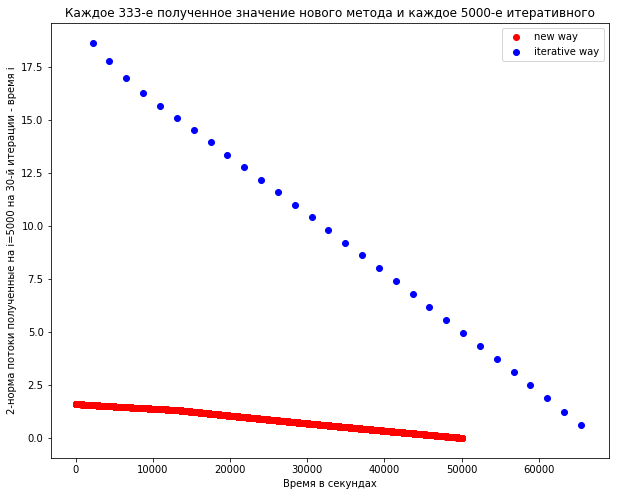

In [79]:
print(len(t_d_nw[::334]),
len(np.arange(0, 30, 1)),
len(t_d[::5000]))

fig = plt.figure(figsize=(10, 8)) 
plt.scatter(X_os_nw, t_d_nw, color='r', label='new way')
plt.scatter(X_os_iw, t_d[::5000], color='b', label='iterative way')
# plt.scatter(range(len(t_d)), flows_w_d, color='b', label='iterative way')
plt.title('Каждое 333-е полученное значение нового метода и каждое 5000-е итеративного')
plt.ylabel('2-норма потоки полученные на i=5000 на 30-й итерации - время i')
plt.xlabel('Время в секундах')
plt.legend()
# plt.xlim(27.5, 30.0)
# plt.ylim(0, 200)
plt.show()
# fig.savefig('KEV_res/iterative pics/flows_w_150000 \
#             - flows_w_prev, COMPARE, flows_w_10000 - flows_w_prev, zoom.png')

##### lists for new-way-case

In [ ]:
array = np.array([1, 2, 3, 4, 5])
array[-1:]

#### На одном графике последние 5000 для итеративного и последние 5000 для нового

In [ ]:
fig = plt.figure(figsize=(10, 8)) 
plt.scatter(range(len(t_d_nw[-4999:])), t_d_nw[-4999:], color='r', label='new way')
plt.scatter(range(len(t_d[-4999:])), t_d[-4999:], color='b', label='iterative way')
plt.title('Последние 5000 итераций итеративного метода и последние 5000 нового')
plt.ylabel('2-норма время полученное на i=5000 на 30-й итерации - время i')
plt.xlabel('Итерации')
plt.legend()
plt.ylim(0.0, 0.0225)
plt.show()
# fig.savefig('KEV_res/iterative pics/T - T_prev, COMPARE, zoom.png')

In [ ]:
fig = plt.figure(figsize=(10, 8)) 
plt.scatter(range(len(flows_w_d_nw[-4999:])), flows_w_d_nw[-4999:], 
            color='r', label='new way')
plt.scatter(range(len(flows_w_d[-4999:])), flows_w_d[-4999:], 
            color='b', label='iterative way')
plt.title('Последние 5000 итераций итеративного метода и последние 5000 нового')
plt.ylabel('2-норма потоки полученное на i=5000 на 30-й итерации - время i')
plt.xlabel('Итерации')
plt.legend()
# plt.ylim(0, 30.0)
plt.show()
fig.savefig('KEV_res/iterative pics/flows_w - flows_w_prev, COMPARE.png')

In [ ]:
fig = plt.figure(figsize=(10, 8)) 
plt.scatter(range(len(flows_w_d_nw)), flows_w_d_nw, 
            color='r', label='new way')
plt.scatter(range(len(flows_w_d)), flows_w_d, 
            color='b', label='iterative way')
plt.title('Все итерации итеративного метода и все нового на одном графике')
plt.ylabel('2-норма потоки полученное на i=5000 на 30-й итерации - время i')
plt.xlabel('Итерации')
plt.legend()
# plt.xlim(0, 10000.0)
plt.show()
fig.savefig('KEV_res/iterative pics/flows_w - flows_w_prev, COMPARE, all in one.png')

In [ ]:
len(range(max_iter)), len(flows_w_d[:4999])

In [ ]:
f = plt.figure(figsize=(30, 20))
plt.title('2-норма время полученное на i=5000 - время i, по итерациям')

ax = f.add_subplot(511)
plt.ylabel('1 итерация')
ax2 = f.add_subplot(512)
plt.ylabel('2 итерация')
ax3 = f.add_subplot(513)
plt.ylabel('3 итерация')
ax4 = f.add_subplot(514)
plt.ylabel('4 итерация')
ax5 = f.add_subplot(515)
plt.ylabel('5 итерация')

ax.scatter(range(max_iter - 1), flows_w_d[:4999])
ax2.scatter(range(max_iter - 1), flows_w_d[4999:9998])
ax3.scatter(range(max_iter - 1), flows_w_d[9998:14997])
ax4.scatter(range(max_iter - 1), flows_w_d[14997:19996])
ax5.scatter(range(max_iter - 1), flows_w_d[19996:24995])
plt.xlabel('номер итерации')

f.savefig('KEV_res/iterative pics/Flows_weight - Flows_weight_prev, 5000 iter, 1-5.png')

In [ ]:
f = plt.figure(figsize=(30, 20))
plt.title('2-норма время полученное на i=5000 - время i, по итерациям')

ax = f.add_subplot(511)
plt.ylabel('1 итерация')
ax2 = f.add_subplot(512)
plt.ylabel('2 итерация')
ax3 = f.add_subplot(513)
plt.ylabel('3 итерация')
ax4 = f.add_subplot(514)
plt.ylabel('4 итерация')
ax5 = f.add_subplot(515)
plt.ylabel('5 итерация')

ax.scatter(range(max_iter - 1), t_d[:4999])
ax2.scatter(range(max_iter - 1), t_d[4999:9998])
ax3.scatter(range(max_iter - 1), t_d[9998:14997])
ax4.scatter(range(max_iter - 1), t_d[14997:19996])
ax5.scatter(range(max_iter - 1), t_d[19996:24995])
plt.xlabel('номер итерации')

f.savefig('KEV_res/iterative pics/T - T_prev, 5000 iter, 1-5.png')

In [ ]:
fig = plt.figure(figsize=(10, 8)) 
plt.scatter(range(max_iter - 1), t_d[19996:24995])
plt.ylabel('Итерация 5. 2-норма время полученное на i=5000 - время i')
plt.xlabel('Итерации')
# plt.xlim(4900.0, 5000.0)
plt.show()
fig.savefig('KEV_res/iterative pics/T - T_prev, 5000 iter, 5-5.png')

In [ ]:
flows_w_d = []
rec_d = []
t_d = []

    
flows_25  = np.loadtxt('KEV_res//iter_arrays//flows//' + str(4) + 
                                    '//' + str(max_iter) + '.txt')
    
times_25 = np.loadtxt('KEV_res//iter_arrays/times//' + str(4) + 
                                    '//' + str(max_iter) + '.txt')

for i in range(0, multi_stage_i):
    for j in range(1, max_iter):
        flows_weighted = np.loadtxt('KEV_res//iter_arrays//flows//' + str(i) + 
                                    '//' + str(j) + '.txt')
        
        t = np.loadtxt('KEV_res//iter_arrays/times//' + str(i) + 
                                    '//' + str(j) + '.txt')

        flows_w_d.append(np.linalg.norm(flows_25 - flows_weighted))
        t_d.append(np.linalg.norm(times_25 - t))

In [ ]:
fig = plt.figure(figsize=(10, 8)) 
plt.scatter(range(len(flows_w_d)), flows_w_d)
plt.ylabel('2-норма потоки полученное на i=5000 на пятой итерации - потоки i')
plt.xlabel('Итерации')
plt.xlim(24000.0, 25000.0)
plt.show()
fig.savefig('KEV_res/iterative pics/Flows_weight - Flows_weight_prev, \
            2400-25000 iter.png')

In [ ]:
fig = plt.figure(figsize=(10, 8)) 
plt.scatter(range(len(t_d)), t_d)
plt.ylabel('2-норма время полученное на i=5000 на пятой итерации - время i')
plt.xlabel('Итерации')
plt.xlim(24000.0, 25000.0)
plt.show()
fig.savefig('KEV_res/iterative pics/T - T_prev, 24000-25000 iter.png')